# Preperations


## Imports


In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import ast
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from upsetplot import plot as upsetplot

from src.consts import PATHS


## Constants

In [15]:
base_output_dir = PATHS.PROJECT_DIR / 'output'

In [16]:
from src.consts import FILTERATIONS
from src.datasets.download_dataset import load_dataset, load_splitted_counter_fact
from src.types import DATASETS, DatasetArgs



In [17]:
df = load_dataset(DatasetArgs(name=DATASETS.COUNTER_FACT, splits="all") )

In [18]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

## Loading Data

### Load Known Files Pre-processed Evaluations
#

In [19]:
correct_files_raw = {
experiment_path.name.replace('minimal_', ''): pd.read_csv(known_1000_correct_file, index_col=0)
    .reset_index(drop=True)
    for experiment_path in base_output_dir.glob('**')
    if (
        known_1000_correct_file := experiment_path
        / "evaluate"
        / "counter_fact.csv"
    ).exists() and 'mamba' in experiment_path.name
}

In [20]:
correct_files_raw['mamba-130M-hf']

,relation,relation_prefix,relation_suffix,prompt,relation_id,attribute,subject,original_idx,model_correct,model_top_output_confidence,target_rank,model_top_outputs,model_generation,target_first_tokens,target_probs,target_tokens,model_output
0,"{}, by",NaN,"{}, by","Rogers Place, by",P127,Edmonton,Rogers Place,13592,False,0.102495,1838,"[[253, "" the"", 0.10249506682157516], [14, ""-"", 0.033152252435684204], [187, ""\n"", 0.023135086521...","the way, is a",NaN,0.000059,"["" Edmonton""]",the
1,The official religion of {} is,The official religion of,is,The official religion of Ibn Ishaq is,P140,Islam,Ibn Ishaq,17956,True,0.224844,1,"[[8033, "" Islam"", 0.2248438149690628], [253, "" the"", 0.12197017669677734], [326, "" that"", 0.0449...",Islam.\n\nThe,NaN,0.224844,"["" Islam""]",Islam
2,{} is affiliated with the religion,NaN,{} is affiliated with the religion,Israel Zolli is affiliated with the religion,P140,Judaism,Israel Zolli,10594,False,0.600599,547,"[[273, "" of"", 0.6005994081497192], [14, ""-"", 0.045452140271663666], [285, "" and"", 0.041454639285...","of Judaism, and is",NaN,0.000053,"["" Judaism""]",of
3,"{}, in",NaN,"{}, in","Nagoya University, in",P17,Japan,Nagoya University,15490,False,0.158115,3,"[[14448, "" collaboration"", 0.15811492502689362], [5864, "" association"", 0.12076772749423981], [4...",collaboration with the University of,NaN,0.112902,"["" Japan""]",collaboration
4,{} is located in,NaN,{} is located in,Abbey of Echternach is located in,P17,Luxembourg,Abbey of Echternach,90,False,0.556503,159,"[[253, "" the"", 0.556503415107727], [444, "" E"", 0.02317523956298828], [247, "" a"", 0.0186367519199...",the municipality of Ech,NaN,0.000408,"["" Luxem"", ""bourg""]",the
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21914,{} is a twin city of,NaN,{} is a twin city of,Rio de Janeiro is a twin city of,P190,Athens,Rio de Janeiro,8024,False,0.269590,403,"[[10869, "" Brazil"", 0.2695898115634918], [253, "" the"", 0.12122104316949844], [767, "" two"", 0.027...",Brazil and the United States,NaN,0.000206,"["" Athens""]",Brazil
21915,The language of {} is,The language of,is,The language of The Archers is,P364,English,The Archers,9012,False,0.059493,4,"[[247, "" a"", 0.05949253961443901], [253, "" the"", 0.03097519651055336], [417, "" not"", 0.022081563...",a bit of a mystery,NaN,0.021603,"["" English""]",a
21916,The law in {} declares the language,The law in,declares the language,The law in Montenegro declares the language,P37,Croatian,Montenegro,819,False,0.310677,248,"[[273, "" of"", 0.3106772005558014], [773, "" \u201c"", 0.0938694179058075], [346, "" \"""", 0.07559845...",of the Constitution to be,NaN,0.000192,"["" Croat"", ""ian""]",of
21917,"{}, the",NaN,"{}, the","Vincent Laban, the",P413,midfielder,Vincent Laban,3648,False,0.051527,2737,"[[15217, "" founder"", 0.0515274852514267], [3438, "" former"", 0.042004842311143875], [1481, "" head...",founder of the French-,NaN,0.000026,"["" midfielder""]",founder


In [21]:
correct_files_raw.keys()

dict_keys(['mamba-130M-hf', 'mamba-2.8B-hf', 'mamba2-2.7B', 'mamba2-130M', 'mamba2-1.3b', 'mamba-1.4B-hf'])

### Preprocess Data

In [49]:
def remove_generation_prefix(df):
    # For some models, the generation is prefixed with the prompt
    return df.apply(
        lambda x: x["model_generation"].removeprefix(
            x["prompt"],
        ),
        axis=1,
    )


def is_correct(target, prediction) -> bool:
    return len(prediction.strip()) > 0 and target.strip().startswith(prediction.strip())


def fix_model_correct(df):
    # Make sure that model_output is at least 1 character long; if empty, it's incorrect
    return df.apply(
        lambda x: is_correct(x["attribute"], x["model_output"]),
        axis=1,
    )


def split_top_outputs(df):
    df = df.copy()
    COL = "model_top_outputs"
    for i in range(len(df[COL].iloc[0])):
        df[f"pred_token_{i+1}"] = (
            df[COL].apply(lambda x: [item[0] for item in x]).apply(lambda x: x[i])
        )
        df[f"pred_{i+1}"] = (
            df[COL].apply(lambda x: [item[1] for item in x]).apply(lambda x: x[i])
        )
        df[f"confidence_{i+1}"] = (
            df[COL].apply(lambda x: [item[2] for item in x]).apply(lambda x: x[i])
        )

    return df.drop(columns=COL)


def correct_output_position(df):
    preds = df.pipe(split_top_outputs)
    preds["correct_position"] = np.inf
    for i in range(1, 6):
        preds["correct_position"] = preds.apply(
            lambda x: (
                min(x["correct_position"], i)
                if is_correct(x["attribute"], x[f"pred_{i}"])
                else x["correct_position"]
            ),
            axis=1,
        )
    return preds["correct_position"]

def confidence_correct(df):
    preds = df.pipe(split_top_outputs)

    return preds.apply(
        lambda x: np.inf if x["correct_position"] > 5 else x[f"confidence_{int(x['correct_position'])}"],
        axis=1,
    )

def confidence_diff(df):
    preds = df.pipe(split_top_outputs)

    return preds.apply(
        lambda x: np.inf if x["correct_position"] > 5 else x["confidence_1"] - x[f"confidence_{int(x['correct_position'])}"],
        axis=1,
    )
    
correct_files = {
    experiment_name: (
        df
        .pipe(lambda df: df.head(len(df)-1))
        .assign(
            **{
                "model_output": lambda df: df["model_output"].fillna(""),
                "model_top_outputs": lambda df: df["model_top_outputs"].apply(ast.literal_eval),
            }
        )
        .assign(
            **{
                "model_generation": remove_generation_prefix,
                # "model_correct": fix_model_correct,
                # "correct_position": correct_output_position,
                "correct_position": lambda df: df["target_rank"],
                'confidence_correct': confidence_correct,
                'confidence_diff': confidence_diff,
            }
        )
        .assign(
            **{
                # "any_correct": lambda df: df["correct_position"] != np.inf,
                "any_correct": lambda df: df["target_rank"] <=5,
            }
        )
    )
    for experiment_name, df in sorted(correct_files_raw.items())
}


In [50]:
model_names = list(correct_files.keys())
model_names

['mamba-1.4B-hf',
 'mamba-130M-hf',
 'mamba-2.8B-hf',
 'mamba2-1.3b',
 'mamba2-130M',
 'mamba2-2.7B']

In [51]:
# Show keys of the files
print(correct_files[next(iter(correct_files))].keys())
print(correct_files.keys())

Index(['relation', 'relation_prefix', 'relation_suffix', 'prompt',
       'relation_id', 'attribute', 'subject', 'original_idx', 'model_correct',
       'model_top_output_confidence', 'target_rank', 'model_top_outputs',
       'model_generation', 'target_first_tokens', 'target_probs',
       'target_tokens', 'model_output', 'correct_position',
       'confidence_correct', 'confidence_diff', 'any_correct'],
      dtype='object')
dict_keys(['mamba-1.4B-hf', 'mamba-130M-hf', 'mamba-2.8B-hf', 'mamba2-1.3b', 'mamba2-130M', 'mamba2-2.7B'])


In [52]:
# Sort known_1000_correct_files by experiment name
per_model_stats_dict = []

# Print experiment details in a hierarchical format
current_arch = None
for model_id, df in correct_files.items():
    df_any_correct = df[df["any_correct"]]
    df_correct = df[df["model_correct"]]
    df_any_correct_but_not_first = df[(df["any_correct"]) & (~df["model_correct"])]
    position_value_counts = df_any_correct["correct_position"].value_counts() / len(df)
    per_model_stats_dict.append({
        "model_id": model_id,
        "accuracy": f"{df['model_correct'].mean():.2%}",
        "accuracy_any_correct": f"{df['any_correct'].mean():.2%}",
        'mean_target_rank': f"{df['target_rank'].mean():.2f}",
        'mean_confidence_model_correct': f"{df_correct['model_top_output_confidence'].mean():.2f}",
        'mean_top_confidence_model_any_correct': f"{df_any_correct['model_top_output_confidence'].mean():.2f}",
        'mean_correct_confidence_model_any_correct': f"{df_any_correct['confidence_correct'].mean():.2f}",
        'mean_correct_confidence_model_correct_but_not_first': f"{df_any_correct_but_not_first['confidence_correct'].mean():.2f}",
        'mean_confidence_diff_model_any_correct_but_not_first': f"{df_any_correct_but_not_first['confidence_diff'].mean():.2f}",
        'mean_confidence_diff': f"{df_any_correct['confidence_diff'].mean(): .2f}",
        'mean_correct_position': f"{df_any_correct['correct_position'].mean():.2f}",
        'mean_correct_top_output_confidence': f"{df_any_correct['model_top_output_confidence'].mean():.2f}",
        ** {
            f"correct_position_{int(position)}": f"{count:.2%}" 
            for position, count in position_value_counts.items()
        }
    })
    
per_model_stats_df = (
    pd.DataFrame(per_model_stats_dict)
)
per_model_stats_df

,model_id,accuracy,accuracy_any_correct,mean_target_rank,mean_confidence_model_correct,mean_top_confidence_model_any_correct,mean_correct_confidence_model_any_correct,mean_correct_confidence_model_correct_but_not_first,mean_confidence_diff_model_any_correct_but_not_first,mean_confidence_diff,mean_correct_position,mean_correct_top_output_confidence,correct_position_1,correct_position_2,correct_position_3,correct_position_4,correct_position_5
0,mamba-1.4B-hf,15.39%,35.52%,450.02,0.37,0.33,0.20,0.07,0.22,0.13,2.16,0.33,15.39%,8.29%,5.22%,3.87%,2.74%
1,mamba-130M-hf,7.90%,23.91%,859.28,0.27,0.25,0.12,0.05,0.18,0.12,2.36,0.25,7.90%,6.52%,4.47%,2.96%,2.07%
2,mamba-2.8B-hf,17.26%,37.90%,394.77,0.41,0.36,0.23,0.07,0.24,0.13,2.12,0.36,17.26%,8.46%,5.57%,3.65%,2.97%
3,mamba2-1.3b,15.32%,36.02%,436.04,0.38,0.33,0.20,0.07,0.22,0.13,2.17,0.33,15.32%,8.94%,5.09%,3.79%,2.89%
4,mamba2-130M,7.95%,22.75%,839.53,0.31,0.27,0.15,0.06,0.19,0.12,2.37,0.27,7.95%,5.89%,3.76%,2.91%,2.24%
5,mamba2-2.7B,16.17%,37.65%,382.01,0.39,0.34,0.21,0.07,0.23,0.13,2.16,0.34,16.17%,9.21%,5.30%,3.85%,3.12%


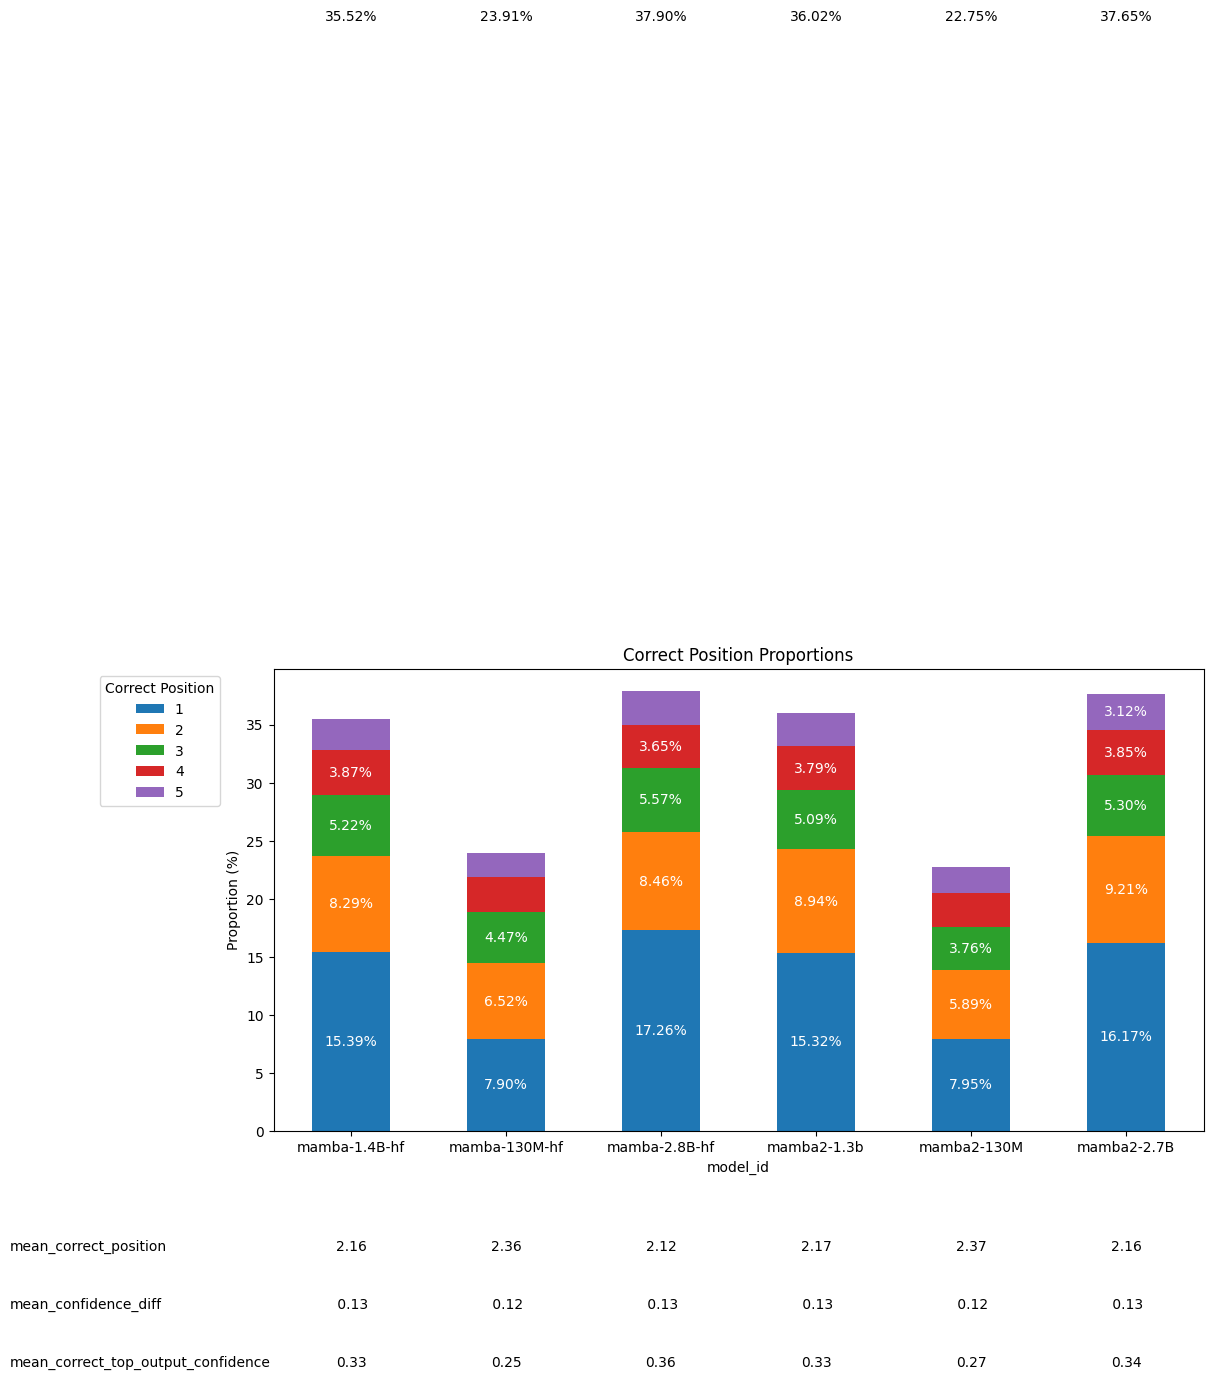

In [53]:
def plot_correct_position_proportions(
    df,
    additional_info_cols=[
        "mean_correct_position",
        "mean_confidence_diff",
        "mean_correct_top_output_confidence",
    ],
):
    rename_col = lambda col: col.replace("correct_position_", "")
    correct_position_cols = [
        col for col in df.columns if col.startswith("correct_position_")
    ]

    correct_position_df = df.assign(
        **{
            rename_col(col): df[col].apply(lambda x: float(x.rstrip("%")))
            for col in correct_position_cols
        }
    ).melt(
        id_vars=["model_id"],
        value_vars=map(rename_col, correct_position_cols),
        var_name="correct_position",
        value_name="proportion",
    )
    
    # Pivot the data to make it suitable for a stacked bar plot
    pivot_df = correct_position_df.pivot_table(
        index=["model_id"], columns="correct_position", values="proportion"
    )

    # Plotting the stacked bar plot
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("Correct Position Proportions")

    plt.ylabel("Proportion (%)")
    plt.xticks(rotation=0)
    plt.legend(title="Correct Position", bbox_to_anchor=(-0.05, 1), loc="upper right")

    n_bars = len(pivot_df)
    height = {i: 0 for i in range(n_bars)}
    # Adding total amount on top of each bar
    for idx, bar in enumerate(ax.patches):
        bar_i = idx % n_bars
        position_i = idx // n_bars
        if bar.get_height() > 3:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height[bar_i] + bar.get_height() / 2,
                f"{pivot_df.iloc[bar_i, position_i]:.2f}%",
                fontsize=10,
                ha="center",
                va="center",
                color="white",
            )

        height[bar_i] += bar.get_height()

    for i, col in enumerate(additional_info_cols):
        ax.text(
            -2.2,
            -10 - i * 5,
            col,
            fontsize=10,
            ha="left",
            va="center",
            color="black",
        )

    # Adding summary on each model
    for i in range(n_bars):
        bar_location = ax.patches[i].get_x() + ax.patches[i].get_width() / 2
        model_stats = df.iloc[i]

        ax.text(
            bar_location,
            96,
            model_stats["accuracy_any_correct"],
            fontsize=10,
            ha="center",
            va="center",
            color="black",
        )

        for j, col in enumerate(additional_info_cols):
            ax.text(
                bar_location,
                -10 - j * 5,
                model_stats[col],
                fontsize=10,
                ha="center",
                va="center",
                color="black",
            )

    # plt.tight_layout()
    plt.show()


plot_correct_position_proportions(per_model_stats_df)

## Combining Data
#

In [54]:
correct_files.keys()

dict_keys(['mamba-1.4B-hf', 'mamba-130M-hf', 'mamba-2.8B-hf', 'mamba2-1.3b', 'mamba2-130M', 'mamba2-2.7B'])

In [55]:
# Predefined constants for column names
INDEX_COL = 'original_idx'
TOTAL_CORRECT_COL = "total_correct"
AGGREEMENT_TYPE_COL = "agreement_type"
MODEL_CORRECT_COL = "model_correct"
INDEX_COLUMNS = ["model_id"]
PER_MODEL_COLS = [
    MODEL_CORRECT_COL,
    "model_output",
    "model_top_output_confidence",
    "model_generation",
    "model_top_outputs",
    'correct_position',
    'confidence_diff',
    'any_correct',
    'target_rank',
    'target_probs',
    'target_tokens',
    'target_first_tokens',
    'confidence_correct',
]
SHARE_COLS = [col for col in df.columns if col not in PER_MODEL_COLS + [INDEX_COL]]

# Processing the data using pipes
result = (
    pd.concat(
        [
            df.assign(**{INDEX_COLUMNS[0]:name})
            for name, df in correct_files.items()
        ]
    )
    .set_index(INDEX_COL)
    .pipe(
        lambda df: (
            pd.concat(
                [
                    df[PER_MODEL_COLS + INDEX_COLUMNS]
                    .set_index(INDEX_COLUMNS[0], append=True)
                    .unstack(level=[-1]),
                    df[SHARE_COLS].drop_duplicates().sort_index(),
                ],
                axis=1,
            )
        )
    )
    .pipe(
        lambda df: df.assign(
            **{
                TOTAL_CORRECT_COL: df[
                    [col for col in df.columns if col[0] == MODEL_CORRECT_COL]
                ].sum(axis=1),
                'total_any_correct': df[
                    [col for col in df.columns if col[0] == 'any_correct']
                ].sum(axis=1),
                AGGREEMENT_TYPE_COL: (
                    df[[col for col in df.columns if col[0] == MODEL_CORRECT_COL]]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
                'any_correct_agreement_type': (
                    df[[col for col in df.columns if col[0] == 'any_correct']]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
            }
        )
    )
)

# Experiments

## Experiment 1 - Value Counts

### Experiment 1.1 - Value Counts for Total Correct

In [56]:
# Print value counts for total_correct
(
    result[TOTAL_CORRECT_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)


total_correct
0    75.79%
1     5.36%
4     4.77%
6     3.77%
2     3.76%
3     3.68%
5     2.87%
Name: proportion, dtype: object

In [57]:
# Print value counts for total_correct
(
    result['total_any_correct']
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)


total_any_correct
0    50.19%
6    15.31%
4     8.42%
1     8.38%
5     6.27%
2     5.80%
3     5.63%
Name: proportion, dtype: object

### Experiment 1.2 - Agreement Type Value Counts
#
In this experiment, we will look at the value counts of the agreement types.
Agreement type is a string that encodes which models agreed on a correct prediction.
#

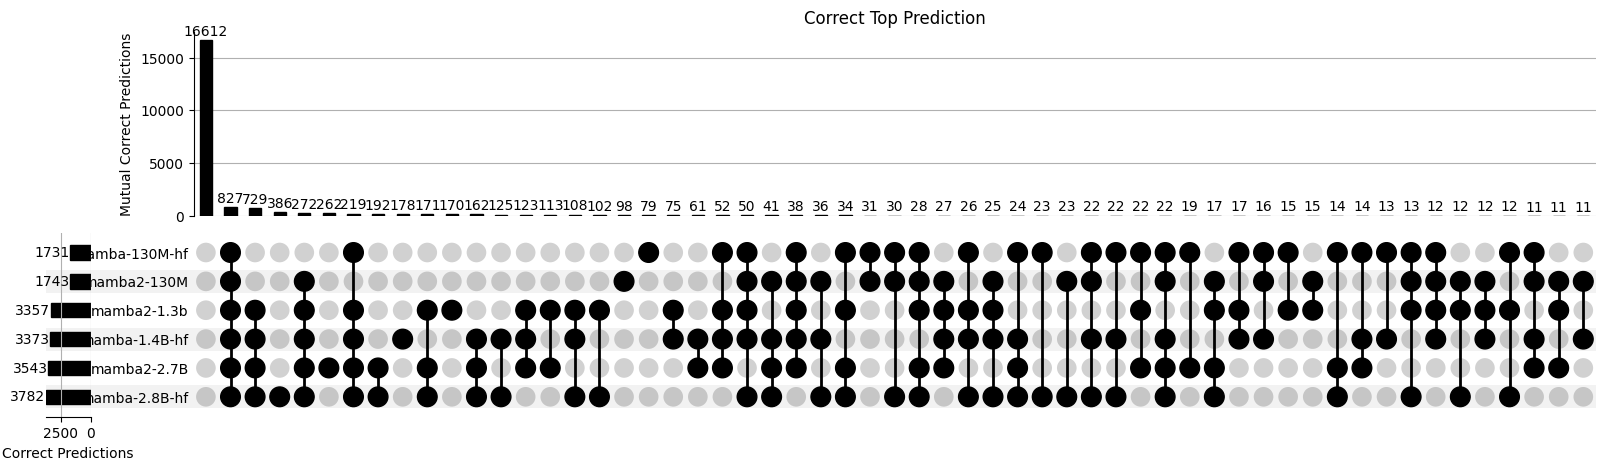

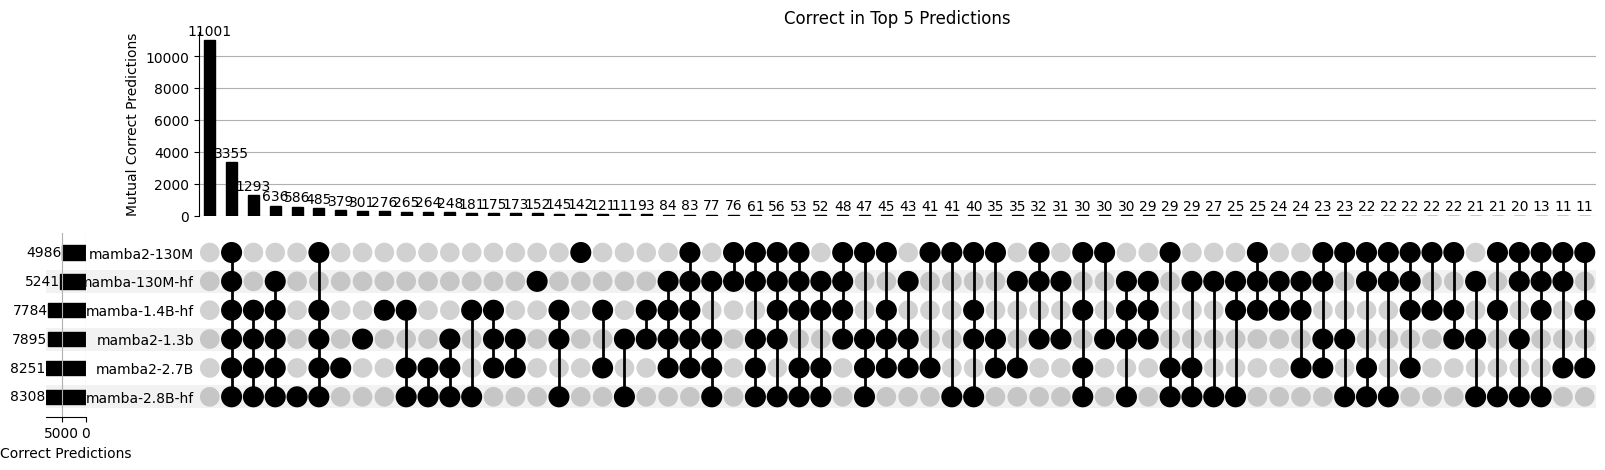

In [58]:
def plot_upset(result, agreement_type_col, title, min_subset_size=10):
    res = (
        result[agreement_type_col]
        .reset_index()
        .assign(**{
            model: lambda df, model=model, i=i: result[agreement_type_col].str[i] == '1'
            for i, model in enumerate(model_names)
        })
        .groupby(model_names)['original_idx'].count()
    )
    
    fig = plt.figure(figsize=(20, 5))
    
    upset = upsetplot(
        res,
        fig=fig,
        orientation='horizontal',
        sort_by='cardinality',
        facecolor='black',
        show_counts=True, 
        min_subset_size=min_subset_size,
        element_size=None,
    )

    upset["intersections"].set_ylabel("Mutual Correct Predictions")
    upset["totals"].set_xlabel("Correct Predictions")
    
    plt.title(title)
    plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_upset(result, AGGREEMENT_TYPE_COL, 'Correct Top Prediction')
    plot_upset(result, 'any_correct_agreement_type', 'Correct in Top 5 Predictions')

### Save filterations

In [59]:
PATHS.COUNTER_FACT_FILTERATIONS_DIR.mkdir(parents=True, exist_ok=True)
result.pipe(lambda df: df[df['total_correct'] == len(model_names)]).reset_index()['original_idx'].to_csv(PATHS.COUNTER_FACT_FILTERATIONS_DIR / f'{FILTERATIONS.all_correct}.csv', index=False)
result.pipe(lambda df: df[df['total_any_correct'] == len(model_names)]).reset_index()['original_idx'].to_csv(PATHS.COUNTER_FACT_FILTERATIONS_DIR / f'{FILTERATIONS.all_any_correct}.csv', index=False)


In [60]:
len(model_names)

6

In [63]:
(result.pipe(lambda df: df[df['total_correct'] == len(model_names)])).loc[[17689]]

,"(model_correct, mamba-1.4B-hf)","(model_correct, mamba-130M-hf)","(model_correct, mamba-2.8B-hf)","(model_correct, mamba2-1.3b)","(model_correct, mamba2-130M)","(model_correct, mamba2-2.7B)","(model_output, mamba-1.4B-hf)","(model_output, mamba-130M-hf)","(model_output, mamba-2.8B-hf)","(model_output, mamba2-1.3b)","(model_output, mamba2-130M)","(model_output, mamba2-2.7B)","(model_top_output_confidence, mamba-1.4B-hf)","(model_top_output_confidence, mamba-130M-hf)","(model_top_output_confidence, mamba-2.8B-hf)","(model_top_output_confidence, mamba2-1.3b)","(model_top_output_confidence, mamba2-130M)","(model_top_output_confidence, mamba2-2.7B)","(model_generation, mamba-1.4B-hf)","(model_generation, mamba-130M-hf)","(model_generation, mamba-2.8B-hf)","(model_generation, mamba2-1.3b)","(model_generation, mamba2-130M)","(model_generation, mamba2-2.7B)","(model_top_outputs, mamba-1.4B-hf)","(model_top_outputs, mamba-130M-hf)","(model_top_outputs, mamba-2.8B-hf)","(model_top_outputs, mamba2-1.3b)","(model_top_outputs, mamba2-130M)","(model_top_outputs, mamba2-2.7B)","(correct_position, mamba-1.4B-hf)","(correct_position, mamba-130M-hf)","(correct_position, mamba-2.8B-hf)","(correct_position, mamba2-1.3b)","(correct_position, mamba2-130M)","(correct_position, mamba2-2.7B)","(confidence_diff, mamba-1.4B-hf)","(confidence_diff, mamba-130M-hf)","(confidence_diff, mamba-2.8B-hf)","(confidence_diff, mamba2-1.3b)","(confidence_diff, mamba2-130M)","(confidence_diff, mamba2-2.7B)","(any_correct, mamba-1.4B-hf)","(any_correct, mamba-130M-hf)","(any_correct, mamba-2.8B-hf)","(any_correct, mamba2-1.3b)","(any_correct, mamba2-130M)","(any_correct, mamba2-2.7B)","(target_rank, mamba-1.4B-hf)","(target_rank, mamba-130M-hf)","(target_rank, mamba-2.8B-hf)","(target_rank, mamba2-1.3b)","(target_rank, mamba2-130M)","(target_rank, mamba2-2.7B)","(target_probs, mamba-1.4B-hf)","(target_probs, mamba-130M-hf)","(target_probs, mamba-2.8B-hf)","(target_probs, mamba2-1.3b)","(target_probs, mamba2-130M)","(target_probs, mamba2-2.7B)","(target_tokens, mamba-1.4B-hf)","(target_tokens, mamba-130M-hf)","(target_tokens, mamba-2.8B-hf)","(target_tokens, mamba2-1.3b)","(target_tokens, mamba2-130M)","(target_tokens, mamba2-2.7B)","(target_first_tokens, mamba-1.4B-hf)","(target_first_tokens, mamba-130M-hf)","(target_first_tokens, mamba-2.8B-hf)","(target_first_tokens, mamba2-1.3b)","(target_first_tokens, mamba2-130M)","(target_first_tokens, mamba2-2.7B)","(confidence_correct, mamba-1.4B-hf)","(confidence_correct, mamba-130M-hf)","(confidence_correct, mamba-2.8B-hf)","(confidence_correct, mamba2-1.3b)","(confidence_correct, mamba2-130M)","(confidence_correct, mamba2-2.7B)",relation,relation_prefix,relation_suffix,prompt,relation_id,attribute,subject,total_correct,total_any_correct,agreement_type,any_correct_agreement_type
original_idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17689,True,True,True,True,True,True,Paris,Paris,Paris,Paris,Paris,Paris,0.106729,0.061348,0.187029,0.110733,0.147916,0.11205,Paris as a painter and,Paris from 1878 to,"Paris as a painter,",Paris as a\ng,Paris from the late 1960,Paris as a painter and,"[[7785, Paris, 0.10672944039106369], [42268, Lyon, 0.03990177810192108], [2398, Mar, 0.038683...","[[7785, Paris, 0.06134830415248871], [418, L, 0.039470527321100235], [24604, Montreal, 0.0290...","[[7785, Paris, 0.18702882528305054], [42268, Lyon, 0.033457547426223755], [14027, Bor, 0.0318...","[[7785, Paris, 0.11073289811611176], [42268, Lyon, 0.03671739250421524], [24604, Montreal, 0....","[[7785, Paris, 0.14791566133499146], [11877, Saint, 0.026062294840812683], [308, T, 0.0237771...","[[7785, Paris, 0.11204955726861954], [42268, Lyon, 0.050663117319345474], [23397, Nancy, 0.03...",1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True,True,True,1,1,1,1,1,1,0.106729,0.061348,0.187029,0.110733,0.147916,0.11205,"["" Paris""]","["" Paris""]","["" Paris""]","["" Paris""]","["" Paris""]","["" Paris""

### check distribution of splits

In [8]:
for filteration in [FILTERATIONS.all_correct, FILTERATIONS.all_any_correct]:
    print(filteration)
    display(pd.DataFrame(
        load_splitted_counter_fact(
            "all", add_split_name_column=True, filteration=filteration
        )
    ).value_counts("split_name"))


all_correct


Filter:   0%|          | 0/21919 [00:00<?, ? examples/s]

split_name
test      409
train2     86
train3     86
train5     86
train4     82
train1     78
Name: count, dtype: int64

all_any_correct


Filter:   0%|          | 0/21919 [00:00<?, ? examples/s]

split_name
test      1698
train1     341
train4     341
train5     334
train3     326
train2     315
Name: count, dtype: int64

### Examples of Agreement Type Mistakes
#

In [295]:
agreement_type_example = '1110000'
i_example = 2

# example = result[result[AGGREEMENT_TYPE_COL] == agreement_type_example].iloc[[i_example]]
example = result[result['any_correct_agreement_type'] == agreement_type_example].iloc[[i_example]]


indexed_columns = [
    col for col in example.columns
    if isinstance(col, tuple)
]

# Print shared_columns
display(example.drop(columns=indexed_columns))

print('-'*50)

(
    example[indexed_columns]
    .melt(var_name='variable', value_name='value')
    .assign(col=lambda df_: df_['variable'].apply(lambda x: x[0]), 
            arch_name=lambda df_: df_['variable'].apply(lambda x: x[1]),
            size=lambda df_: df_['variable'].apply(lambda x: x[2]))
    .drop(columns=['variable'])
    .pivot(index=INDEX_COLUMNS, columns='col', values='value')
    .drop(columns=['model_output', 'model_top_output_confidence'])
    .pipe(split_top_outputs)
)


IndexError: positional indexers are out-of-bounds

## Experiment 2 - Relation ID Interactions
#
### Value Counts for Relation ID
#

In [296]:
# Value counts for relation_id
result['relation_id'].value_counts().tail(10)


relation_id
P39     476
P127    433
P140    430
P108    350
P641    318
P138    279
P407    216
P463    163
P36     139
P264     53
Name: count, dtype: int64

### Aggregated Statistics for Relation ID
#

In [297]:
# Aggregated statistics for relation_id
# Only keep relation_ids that appear at least 25 times, then get top 100 per id
top_relation_ids = (
    result
    .pipe(lambda df: df[df['relation_id'].map(df['relation_id'].value_counts()) >= 25])
    .groupby('relation_id')[AGGREEMENT_TYPE_COL]
    .value_counts()
    .groupby(level=0)
    .head(100)
    .unstack(level=0)
)

# Display aggregated statistics
display(top_relation_ids)


relation_id,P101,P103,P106,P108,P127,P1303,P131,P136,P138,P140,P1412,P159,P17,P176,P178,P19,P190,P20,P264,P27,P276,P30,P36,P364,P37,P39,P407,P413,P449,P463,P495,P641,P740,P937
agreement_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000,473.0,489.0,552.0,295.0,358.0,408.0,669.0,842.0,269.0,276.0,900.0,424.0,721.0,145.0,134.0,711.0,612.0,738.0,53.0,507.0,510.0,733.0,72.0,495.0,511.0,471.0,153.0,909.0,592.0,148.0,837.0,227.0,727.0,748.0
0001,11.0,7.0,6.0,12.0,13.0,15.0,10.0,NaN,1.0,44.0,2.0,47.0,11.0,22.0,21.0,15.0,1.0,14.0,NaN,50.0,14.0,27.0,23.0,55.0,53.0,NaN,21.0,9.0,27.0,1.0,15.0,4.0,8.0,8.0
0010,6.0,1.0,NaN,1.0,5.0,1.0,4.0,NaN,2.0,NaN,20.0,11.0,2.0,23.0,1.0,4.0,2.0,4.0,NaN,9.0,19.0,NaN,1.0,NaN,3.0,NaN,1.0,NaN,13.0,4.0,1.0,NaN,NaN,5.0
0011,1.0,6.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,8.0,3.0,2.0,NaN,1.0,NaN,6.0,NaN,NaN,1.0,NaN,3.0,NaN,2.0,NaN,4.0,NaN,NaN,2.0,NaN,4.0
0100,11.0,38.0,4.0,12.0,23.0,48.0,19.0,3.0,3.0,17.0,2.0,65.0,36.0,72.0,20.0,9.0,4.0,12.0,NaN,77.0,28.0,16.0,7.0,22.0,23.0,2.0,14.0,24.0,51.0,4.0,19.0,12.0,21.0,20.0
0101,9.0,73.0,4.0,26.0,9.0,37.0,10.0,NaN,3.0,44.0,NaN,124.0,66.0,130.0,102.0,24.0,1.0,21.0,NaN,134.0,14.0,65.0,16.0,45.0,100.0,2.0,11.0,10.0,73.0,NaN,23.0,47.0,15.0,20.0
0110,2.0,11.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,2.0,2.0,51.0,4.0,4.0,1.0,NaN,NaN,2.0,10.0,NaN,NaN,NaN,2.0,NaN,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
0111,2.0,28.0,22.0,2.0,3.0,NaN,1.0,NaN,NaN,4.0,NaN,13.0,12.0,158.0,27.0,3.0,NaN,4.0,NaN,19.0,8.0,7.0,1.0,NaN,27.0,1.0,NaN,NaN,8.0,NaN,2.0,4.0,NaN,5.0
1000,10.0,3.0,9.0,NaN,4.0,NaN,1.0,NaN,NaN,4.0,NaN,2.0,4.0,NaN,1.0,1.0,NaN,6.0,NaN,20.0,NaN,6.0,2.0,29.0,17.0,NaN,1.0,NaN,7.0,6.0,2.0,4.0,2.0,4.0


### Visualizing - Heatmap of Relation IDs
#

ValueError: Unknown format code 'd' for object of type 'float'

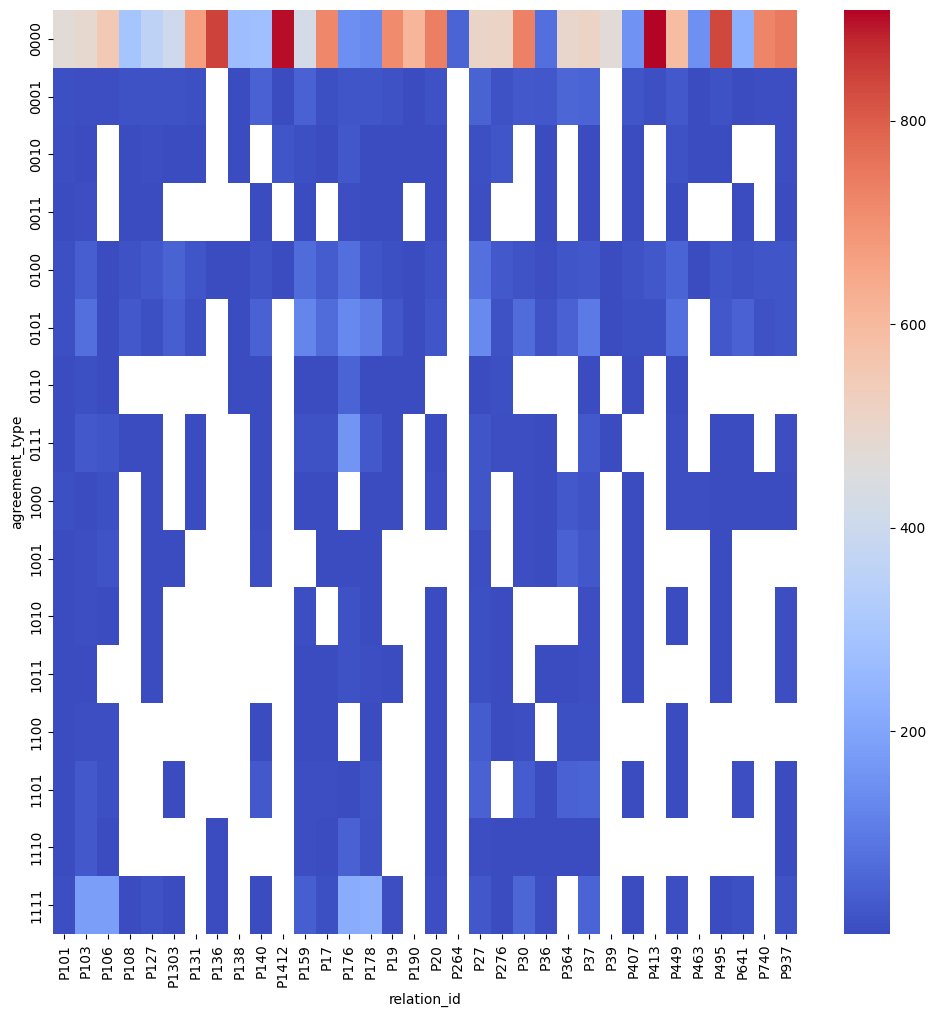

In [298]:
plt.figure(figsize=(12, 12))
sns.heatmap(top_relation_ids, annot=True, fmt='d', cmap='coolwarm')
plt.title('Top 100 Correct Predictions per Relation ID')
plt.show()